In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc.single_pred import ADME
import matplotlib.pyplot as plt
from tdc.single_pred import ADME
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
from tdc.single_pred import ADME
adme = ADME(name='CYP2C19_Veith').get_data(format = 'dict')
X, y = adme['Drug'], adme['Y']
X_morgan = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=1024) for smiles in X]
X_morgan_np = np.array([np.array(fp) for fp in X_morgan])
y = np.array(y)
data = list(zip(X_morgan_np, y))

Found local copy...
Loading...
Done!


In [4]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.length = len(self.X)  # 데이터의 길이 저장
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx >= self.length:
            idx = idx % self.length  # 인덱스가 데이터의 범위를 벗어나면 나머지 연산을 통해 인덱스를 조정
        return self.X[idx], self.y[idx]

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1024, 256)  # 입력 크기: 2, 출력 크기: 2
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2) # 입력 크기: 2, 출력 크기: 1

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

In [6]:
def acc(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {(correct/total)*100:.2f}%")

In [7]:
lr = 1e-3
num_epochs = 50
model = MLP().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr)
criterion = nn.CrossEntropyLoss().to(device)

# Cross-validation을 반복하여 각 반복에서의 점수를 저장할 리스트 생성
cv_acc_scores = []
cv_precision_scores = []
cv_recall_scores = []
cv_f1_scores = []
cv_roc_auc_scores = []

acc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [8]:
for repeat in range (0, 10):
    k_folds=5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_morgan_np)):
        print(f'Fold {fold + 1}/{k_folds}')
        X_train, X_val = X_morgan_np[train_idx], X_morgan_np[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
    
        # 사용자 정의 데이터셋 생성
        train_dataset = CustomDataset(X_train, y_train)
        val_dataset = CustomDataset(X_val, y_val)
    
        # 데이터로더 생성
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
        torch.nn.init.kaiming_uniform_(model.fc1.weight)
        torch.nn.init.kaiming_uniform_(model.fc2.weight)
        torch.nn.init.kaiming_uniform_(model.fc3.weight)
        
        # 모델 훈련
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if (epoch+1)%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
                
        # 정확도
        model.eval()
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        y_true = np.array(val_preds)
        y_pred = np.array(val_targets)
        
        acc_scores.append(accuracy_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred))
        roc_auc_scores.append(roc_auc_score(y_true, y_pred))

    # Cross-validation 점수의 평균 계산
    cv_acc_scores.append(np.mean(acc_scores))
    cv_precision_scores.append(np.mean(precision_scores))
    cv_recall_scores.append(np.mean(recall_scores))
    cv_f1_scores.append(np.mean(f1_scores))
    cv_roc_auc_scores.append(np.mean(roc_auc_scores))
    
# Cross-validation 점수의 평균 계산
mean_acc_score = np.mean(cv_acc_scores)
mean_precision_score = np.mean(cv_precision_scores)
mean_recall_score = np.mean(cv_recall_scores)
mean_f1_score = np.mean(cv_f1_scores)
mean_roc_auc_score = np.mean(cv_roc_auc_scores)

# Cross-validation 점수의 표준 편차 계산
std_dev_acc= np.std(cv_acc_scores)
std_dev_precision = np.std(cv_precision_scores)
std_dev_recall = np.std(cv_recall_scores)
std_dev_f1 = np.std(cv_f1_scores)
std_dev_roc_auc = np.std(cv_roc_auc_scores)        
    
print("ACC:",mean_acc_score)
print("recall:",mean_recall_score)
print("precision:",mean_precision_score)
print("F1:",mean_f1_score)
print("ROC_AUC:",mean_roc_auc_score)

Fold 1/5
Epoch 10/50, Loss: 0.6409007292123711
Epoch 20/50, Loss: 0.5932307052162459
Epoch 30/50, Loss: 0.5559387055208098
Epoch 40/50, Loss: 0.5265982203513572
Epoch 50/50, Loss: 0.5056608113102943
Fold 2/5
Epoch 10/50, Loss: 0.624595654460619
Epoch 20/50, Loss: 0.5783782856269453
Epoch 30/50, Loss: 0.5437986860110325
Epoch 40/50, Loss: 0.5168965717531601
Epoch 50/50, Loss: 0.49616675106984265
Fold 3/5
Epoch 10/50, Loss: 0.6270021818718821
Epoch 20/50, Loss: 0.5775142529475614
Epoch 30/50, Loss: 0.5404499015718136
Epoch 40/50, Loss: 0.5127858172797557
Epoch 50/50, Loss: 0.49189332146314707
Fold 4/5
Epoch 10/50, Loss: 0.639029472878894
Epoch 20/50, Loss: 0.5881834241954036
Epoch 30/50, Loss: 0.5473807469104071
Epoch 40/50, Loss: 0.5168045333721353
Epoch 50/50, Loss: 0.49500120342152676
Fold 5/5
Epoch 10/50, Loss: 0.6022018070490855
Epoch 20/50, Loss: 0.5490235474499516
Epoch 30/50, Loss: 0.5151773518736258
Epoch 40/50, Loss: 0.4908998766035404
Epoch 50/50, Loss: 0.47308070798340085
Fol

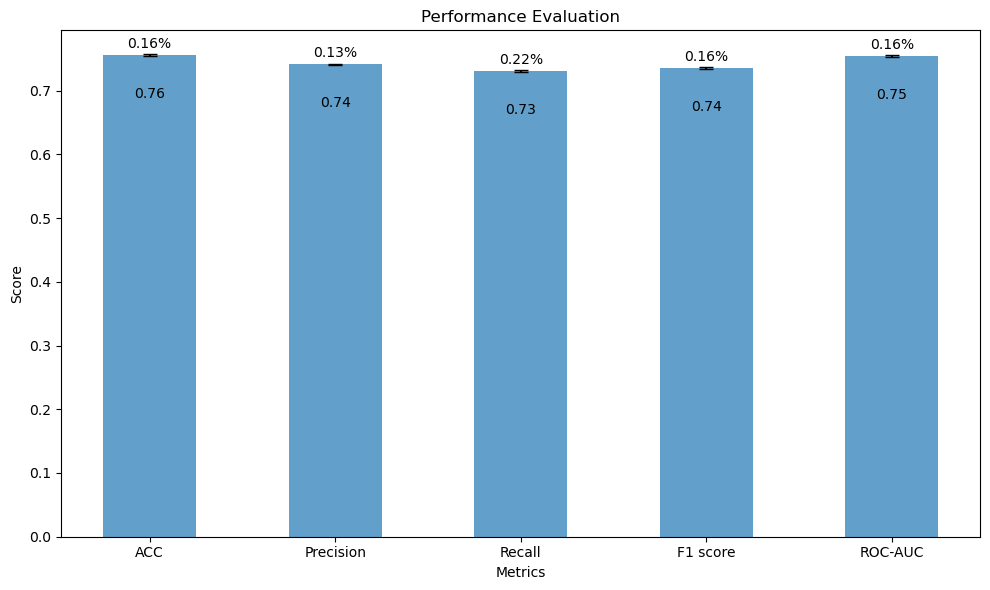

In [9]:
# 각 평가 지표의 평균과 표준 편차
mean_scores = [mean_acc_score, mean_precision_score, mean_recall_score, mean_f1_score, mean_roc_auc_score]
std_devs = [std_dev_acc, std_dev_precision, std_dev_recall, std_dev_f1, std_dev_roc_auc]

# 그래프에 표시할 평가 지표 이름
metrics = ['ACC', 'Precision', 'Recall', 'F1 score', 'ROC-AUC']

# 에러율 계산
error_values = [std_dev / mean_score for std_dev, mean_score in zip(std_devs, mean_scores)]

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 그리기
bar = plt.bar(metrics, mean_scores, yerr=std_devs, capsize=5, alpha=0.7, width=0.5)

# 에러율 표시
for i in range(len(metrics)):
    plt.text(i, mean_scores[i] + std_devs[i] + 0.01, f'{error_values[i]*100:.2f}%', ha='center')
    
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height-0.05, f'{height:.2f}', ha='center', va='top')

# 그래프 제목과 라벨 설정
plt.title('Performance Evaluation')
plt.xlabel('Metrics')
plt.ylabel('Score')

# 그래프 보이기
plt.tight_layout()
plt.show()